# Clustering Techniques -- Beyond K-Means

Understanding the similarities and differences in data is a foundational challenge to any business's data strategy. Whether it's identifying customers with shared nuances and idiosyncrasies or determining homogeneous gene sequences for cancer research, several techniques exist for grouping data -- otherwise known as clustering to the data science world or segmentation to the business world.

One of the most commonly used methods by analytics practitioners is K-Means Clustering. Its easy-to-understand process and variety of applications make it a popular technique and probably the first (if not only) clustering method taught to statistics students. Yet for all that K-Means is good for, it isn't a panacea. Like all statistical modeling methods it has its pros, cons, and of course, underlying assumptions. Today we're going to explore alternative clustering techniques to K-Means for situations were its performance can be suboptimal.

## Assumptions of K-Means

For the sake of brevity, I'll assume the reader has an understanding of how K-Means works (for a refresher, go [here](https://en.wikipedia.org/wiki/K-means_clustering)). Some of the underlying assumptions that make K-Means an efficient clustering technique (especially on the very large data sets you'd expect to find in a productionized big data solution) also can be its greatest weaknesses. While there's no doubt that K-Means will cluster any data you feed into it, the resulting clusters may not realistically capture the underlying relationships an analyst seeks to find.

Let's explore three assumptions of K-Means that, if violated, can result in poor or downright inaccurate clusters:

* Clusters are approximately spherical.
* Clusters are approximately the same size (i.e. contain the same number of data points) and have similar variance.
* All data points belong to a cluster.

It should be noted that even when these assumptions *are* met, the iterative nature and randomized placement of centroids at algorithm initialization can lead K-Means to cluster data differently with each run if not reach convergence at local optima rather than global. As with any statistical technique, never blindly apply and accept the results!

## Clusters are approximately spherical

Real life data is almost always messy. The examples and illustrations we see in our statistics courses are designed to reflect ideal situations that sadly almost never occur. The first assumption of the K-Means algorithm we'll cover is a good example of this.

For K-Means to deliver adequate results clusters must be roughly spherical. If we think about a simple case where our data is 2-dimensional this would mean that data points form round "blobs" when plotted. This amounts to the distributions of each cluster being approximately Gaussian. For example, if one were to plot Age against Net Worth for everyone in the United States you might expect data of this shape -- Net Worth most often increases with Age but there is some variability within each dimension. This segues into the other half of this assumption.

Let's visualize two toy data sets to illustrate:

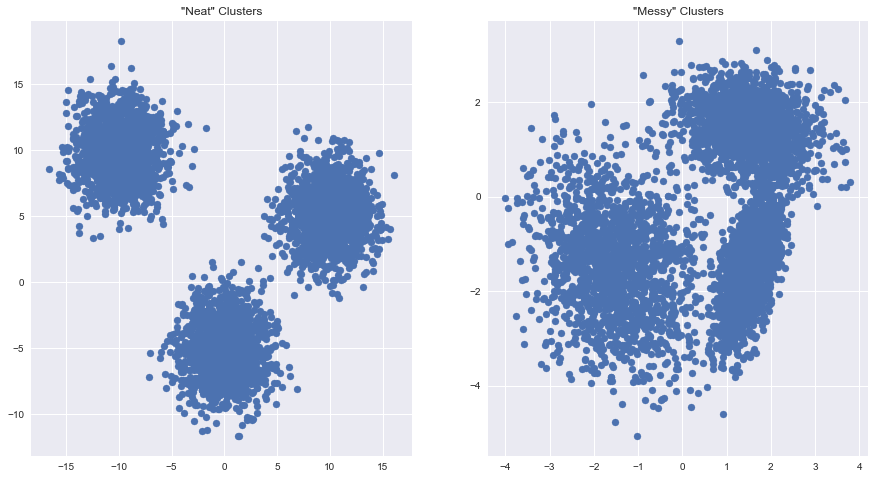

In [2]:
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

#Toy data sets
centers_neat = [(-10, 10), (0, -5), (10, 5)]
x_neat, _ = datasets.make_blobs(n_samples=5000, 
                                centers=centers_neat,
                                cluster_std=2,
                                random_state=2)

x_messy, _ = datasets.make_classification(n_samples=5000,
                                          n_features=10,
                                          n_classes=3,
                                          n_clusters_per_class=1,
                                          class_sep=1.5,
                                          shuffle=False,
                                          random_state=301)
#Default plot params
plt.style.use('seaborn')
cmap = 'tab10'

plt.figure(figsize=(15,8))
plt.subplot(121, title='"Neat" Clusters')
plt.scatter(x_neat[:,0], x_neat[:,1])
plt.subplot(122, title='"Messy" Clusters')
plt.scatter(x_messy[:,0], x_messy[:,1])

Our data set on the left seems to clearly exhibit having three well-defined clusters while the set on the right is a little more... nebulous. Is it two clusters? Maybe three? While visualization via a scatter plot allows us to inspect our data for obvious clusters, K-Means does not *see* like we do and will adhere to the algorithm (as well as to the number of clusters we indicate exist *before* running it -- the "K" in "K-Means").

The "Messy" plot violates both the spherical and variability assumptions. The data points in the top half seem to form one or two clusters, are approximately round, and have similar variance but the data points situated near the bottom half appear linear and seem more dense (i.e. lower variance).

Let's see how K-Means would cluster the above two data sets.

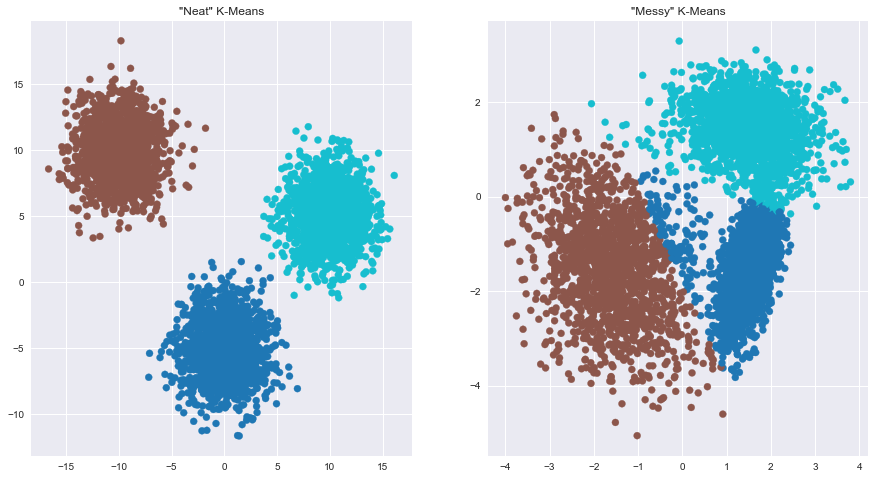

In [3]:
from sklearn.cluster import KMeans

#Predict K-Means cluster membership
km_neat = KMeans(n_clusters=3, random_state=2).fit_predict(x_neat)
km_messy = KMeans(n_clusters=3, random_state=2).fit_predict(x_messy)

plt.figure(figsize=(15,8))
plt.subplot(121, title='"Neat" K-Means')
plt.scatter(x_neat[:,0], x_neat[:,1], c=km_neat, cmap=cmap)
plt.subplot(122, title='"Messy" K-Means')
plt.scatter(x_messy[:,0], x_messy[:,1], c=km_messy, cmap=cmap)

Interesting results to say the least. While the performance on the "Neat" data set achieves excellent clustering, our "Messy" data set (while not clustered all *that* bad) leaves something to be desired. As stated before: visually, we can see two, maybe three, clusters but K-Means creates partitions that don't particularly reflect that. Our clusters are of varying shapes and variances which proves challenging for K-Means to work with. 

Various metrics exist to measure how well we've clustered our data ("well" meaning the distance between data points within the same cluster is minimized while distance between data points in separate clusters is maximized). But if we approach this data like we would data we've never seen before and know nothing about -- let alone what cluster each data point belongs to -- we can't use a measurement like Precision, Recall, Accuracy, F-Score or any other classification measure that relies on us knowing this beforehand. So, we'll use the Silhouette Score which gives us a score between -1 and 1 to quantify how "well" (as we defined above) our clusters are defined:

$$s = \frac{b-a}{max(a,b)}$$

Taken from scikit-learn's [documentation](http://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation):

**a**: The mean distance between a sample and all other points in the same class.

**b**: The mean distance between a sample and all other points in the next nearest cluster.

So a score of "-1" indicates that clustering is poor or non-existent while a "0" indicates heavy overlap and "1" indicates excellent clustering. Let's evaluate our clusters for both our "Neat" and "Messy" data sets.

In [4]:
from sklearn.metrics import silhouette_score

#Compute Silhouette Score
ss_km_neat = silhouette_score(x_neat, km_neat)
ss_km_messy = silhouette_score(x_messy, km_messy)
print('Neat: {}'.format(ss_km_neat))
print('Messy: {}'.format(ss_km_messy))

Neat: 0.7674292736969437
Messy: 0.26856860830818224


As we'd expect, our "Neat" data scores well. For "Messy," a score of `0.269` isn't awful, but isn't optimal. Visually we can see where clustering is going wrong in our data and we'd like to tighten that up. One technique up to the challenge is Gaussian Mixture Models.

### Gaussian Mixture Models

Gaussian Mixture Models (GMMs) work well on data sets where clusters might not be spherical and might have different variances. GMMs are really probabilistic models that assign data points to clusters through the Expectation Maximization (EM) algorithm. This is also good for when clusters tend to overlap (data points are given a "soft assignment" to clusters in the form of probabilities of their membership to each). As you can see in our "Messy" data set, this tends to be the case.

Similar to K-Means, GMMs require us to indicate the number of clusters a priori. GMMs assume that data points within each cluster are Gaussian (normally) distributed with unknown mean and variance. The role of EM is to estimate the parameters for each cluster's mean/variance that maximizes the likelihood of the observed data.

EM works similar to K-Means: First, we generate random means/variances for each distribution (cluster) we want to fit to our data then we look at each data point and ask "Given the parameters of each cluster we generated, what is the probability this data point came from each cluster?" This is the **Expectation** part of EM. Second, we update the means/variances of these distributions to better fit the data points assigned to them with the highest probability of membership. This is the **Maximization** part. Like K-Means we iterate back and forth until our means/variances stabilize. GMMs

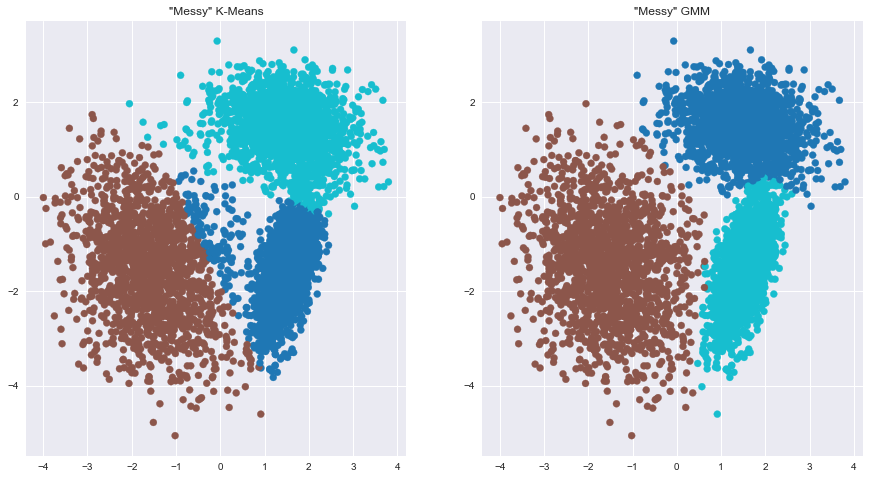

In [5]:
from sklearn.mixture import GaussianMixture

#Predict GMM cluster membership
gm_messy = GaussianMixture(n_components=3).fit(x_messy).predict(x_messy)

plt.figure(figsize=(15,8))
plt.subplot(121, title='"Messy" K-Means')
plt.scatter(x_messy[:,0], x_messy[:,1], c=km_messy, cmap=cmap)
plt.subplot(122, title='"Messy" GMM')
plt.scatter(x_messy[:,0], x_messy[:,1], c=gm_messy, cmap=cmap)

Simply from a visual standpoint we can see that GMM does a better job than K-Means of teasing out better fitting cluster assignments. Yet, GMM also has its shortcomings: it assumes the data is normally distributed across dimensions and the number of clusters is known a priori like K-Means (although this can be addressed by modeling with different cluster counts and choosing the model with the best BIC score). It can also fail to provide ideal clusters unless they have roughly the same number of data points which we'll look at next.

## Clusters are approximately the same size

If you were to develop a customer segmentation model for your retail business, you would most likely not have your customers fall into clusters with the same number of individuals in them. The real world is never *that* kind to analysts! In our above example with GMMs the toy data was generated with `n ~ 1,667` in each cluster (or, `5000 / 3`). What would happen if cluster membership was imbalanced?

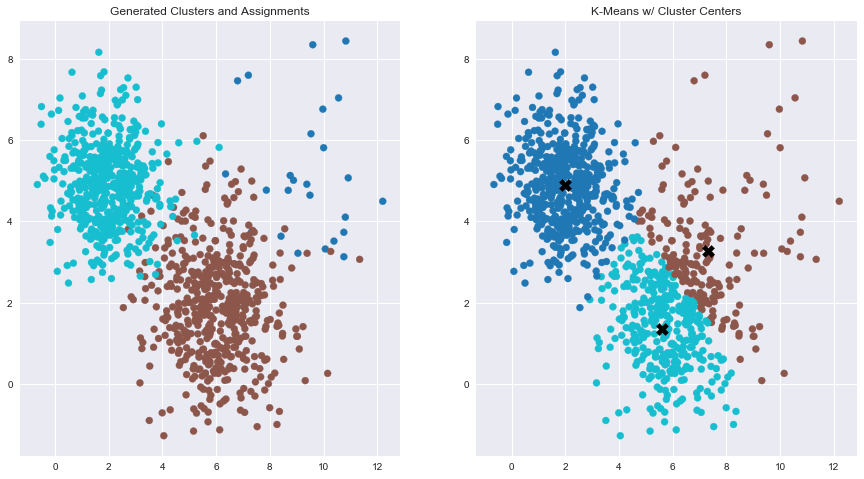

In [71]:
import numpy as np

#Toy data set
blob1, y1 = datasets.make_blobs(n_samples=25, 
                               centers=[(10,5)],
                               cluster_std=1.5,
                               random_state=2)

blob2, y2 = datasets.make_blobs(n_samples=500, 
                               centers=[(6,2)],
                               cluster_std=1.3,
                               random_state=2)

blob3, y3 = datasets.make_blobs(n_samples=500, 
                               centers=[(2,5)],
                               cluster_std=1,
                               random_state=2)

unbal = np.vstack([blob1, blob2, blob3])
y1[y1 == 0] = 0
y2[y2 == 0] = 1
y3[y3 == 0] = 2
labs = np.concatenate([y1, y2, y3])

#Predict K-Means cluster membership
km_unbal = KMeans(n_clusters=3, random_state=2).fit(unbal)
km_unbal_preds = KMeans(n_clusters=3, random_state=2).fit_predict(unbal)

plt.figure(figsize=(15,8))
plt.subplot(121, title='Generated Clusters and Assignments')
plt.scatter(unbal[:,0], unbal[:,1], c=labs, cmap=cmap)
plt.subplot(122, title='K-Means w/ Cluster Centers')
plt.scatter(unbal[:,0], unbal[:,1], c=km_unbal_preds, cmap=cmap)
plt.scatter(km_unbal.cluster_centers_[:,0], km_unbal.cluster_centers_[:,1], marker='X', s=150, c='black')

Our toy data set is designed with two large clusters and one sparse cluster (`n = 500, 500, 25`) creating significant imbalance. The two plots above demonstrate how K-Means can misclassify data points when this occurs. On the left we see the points colored according to the "ground truth" as generated by our data simulator whereas on the right we see how K-Means classifies our data points. Clearly the brown cluster centroid is encroaching on the nearest large cluster leading to it "stealing" some of its data points. This is because K-Means is trying to reduce the within-cluster sum of squared differences so centroids naturally "gravitate" towards larger densities of data points -- especially if we have specified a greater number of clusters than what might naturally be occurring in our data.   

While testing different cluster counts and evaluating them via the Silhouette Score can help us improve this a bit, it brings us to a decision point: even if our Silhouette Score indicates two clusters work better than three, one things we haven't considered up to this point: how are we to know we aren't including outliers? K-Means classifies *every* data point into a cluster no matter how far away it is from the nearest centroid. Do we have a third cluster or just a set of data points that don't belong anywhere? Think of how these implications could impact business decisions...

Density-based clustering methods are one way of addressing these situations with the most popular method being DBSCAN (**D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise). DBSCAN differs from K-Means in a few important ways. One, DBSCAN does not require the analyst to select the number of clusters a priori -- the algorithm determines this based on the parameters it's given. Two, it excels at clustering non-spherical data and three, it does not force every data point into a cluster -- if a data point lies outside of the specified starting parameters, it will be classified as "noise" and not included in any resulting cluster.

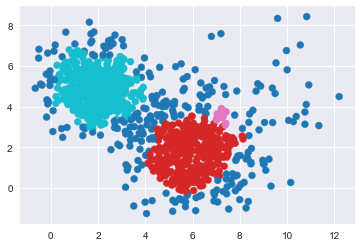

In [95]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=.4, min_samples=12).fit_predict(unbal)
plt.scatter(unbal[:,0], unbal[:,1], c=dbscan, cmap=cmap)

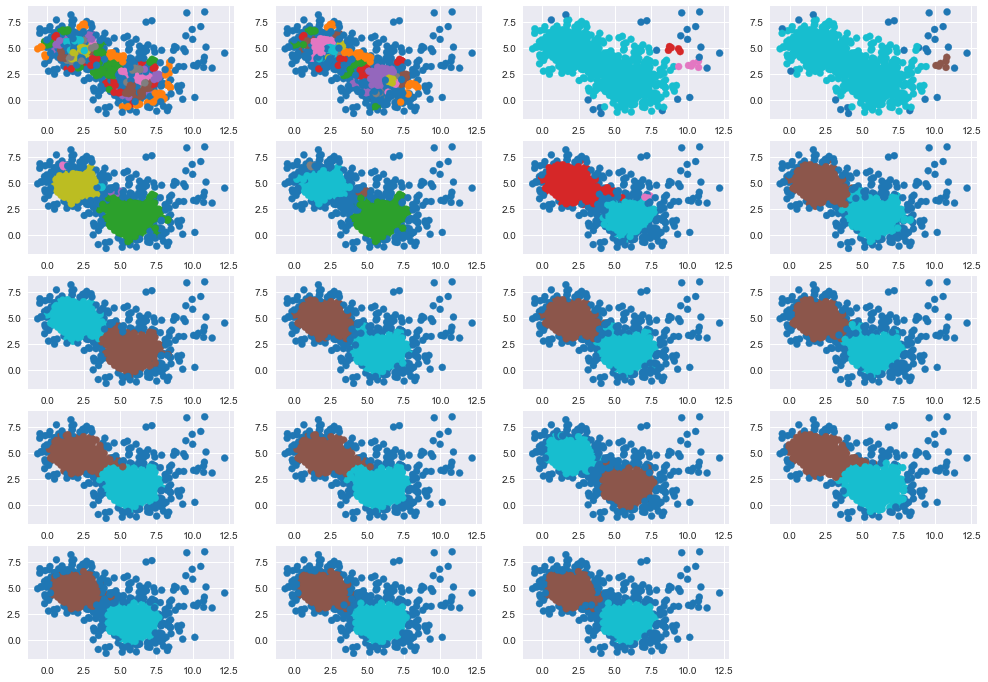

In [129]:
import hdbscan

clust_count = np.linspace(1, 20, num=20, dtype='int')

clust_number = 2
plot_number = 1
plt.figure (figsize=(17,12))
while clust_number < 21:
    hdb = hdbscan.HDBSCAN(min_cluster_size=clust_number)
    hdb_pred = hdb.fit(unbal)
    plt.subplot(5, 4, plot_number)
    plt.scatter(unbal[:,0], unbal[:,1], c=hdb_pred.labels_, cmap=cmap)
    plot_number += 1
    clust_number += 1
    
#hdb = hdbscan.HDBSCAN(min_cluster_size=7)
#hdb_pred = hdb.fit(unbal)
#plt.scatter(unbal[:,0], unbal[:,1], c=hdb_pred.labels_, cmap=cmap)

In [121]:
clust_count.dtype

dtype('int32')